In [21]:
import pandas as pd

print("Tout fonctionne, Pandas est prêt !")

Tout fonctionne, Pandas est prêt !


In [22]:
# Correction du chemin :
# 1. On enlève le nom du dossier parent (car on est déjà dedans)
# 2. On met des slashs normaux /
# 3. On corrige la fin du fichier (.gz au lieu de .gzip)

chemin = "données/title.basics.tsv.gz"

# On charge le fichier
df_basics = pd.read_csv(chemin, sep='\t', compression='gzip', nrows=50)

df_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short


In [3]:
# On charge tout le fichier (j'ai enlevé nrows)
# low_memory=False permet d'éviter un avertissement technique sur les types de colonnes mélangés
df_basics = pd.read_csv(chemin, sep='\t', compression='gzip', low_memory=False)

print("Chargement terminé ! Le fichier est en mémoire.")

Chargement terminé ! Le fichier est en mémoire.


In [4]:
# Affiche le résumé des données : nombre de lignes, noms des colonnes, types de données
df_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12068990 entries, 0 to 12068989
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         int64 
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: int64(1), object(8)
memory usage: 828.7+ MB


In [5]:
# Compte combien il y a de films, de courts-métrages, d'épisodes, etc.
df_basics['titleType'].value_counts()

titleType
tvEpisode       9301106
short           1095042
movie            731955
video            318472
tvSeries         290725
tvMovie          153010
tvMiniSeries      66345
tvSpecial         55657
videoGame         45868
tvShort           10809
tvPilot               1
Name: count, dtype: int64

In [6]:
# 1. LE FILTRAGE : On ne garde que les lignes où titleType est 'movie'
# .copy() permet de créer un tableau indépendant pour éviter des avertissements bizarres plus tard
df_movies = df_basics[df_basics['titleType'] == 'movie'].copy()

print(f"Après filtrage, il nous reste {len(df_movies)} films. On respire !")

# 2. LE NETTOYAGE : On convertit les colonnes en nombres
# 'coerce' veut dire : "Si tu trouves un truc bizarre (comme \N), transforme-le en NaN (vide)"
cols_to_fix = ['startYear', 'runtimeMinutes']

for col in cols_to_fix:
    df_movies[col] = pd.to_numeric(df_movies[col], errors='coerce')

# 3. VERIFICATION
print("\nNouveaux types de données :")
df_movies.info()

Après filtrage, il nous reste 731955 films. On respire !

Nouveaux types de données :
<class 'pandas.core.frame.DataFrame'>
Index: 731955 entries, 8 to 12068940
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          731955 non-null  object 
 1   titleType       731955 non-null  object 
 2   primaryTitle    731952 non-null  object 
 3   originalTitle   731952 non-null  object 
 4   isAdult         731955 non-null  int64  
 5   startYear       623724 non-null  float64
 6   endYear         731955 non-null  object 
 7   runtimeMinutes  462189 non-null  float64
 8   genres          731955 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 55.8+ MB


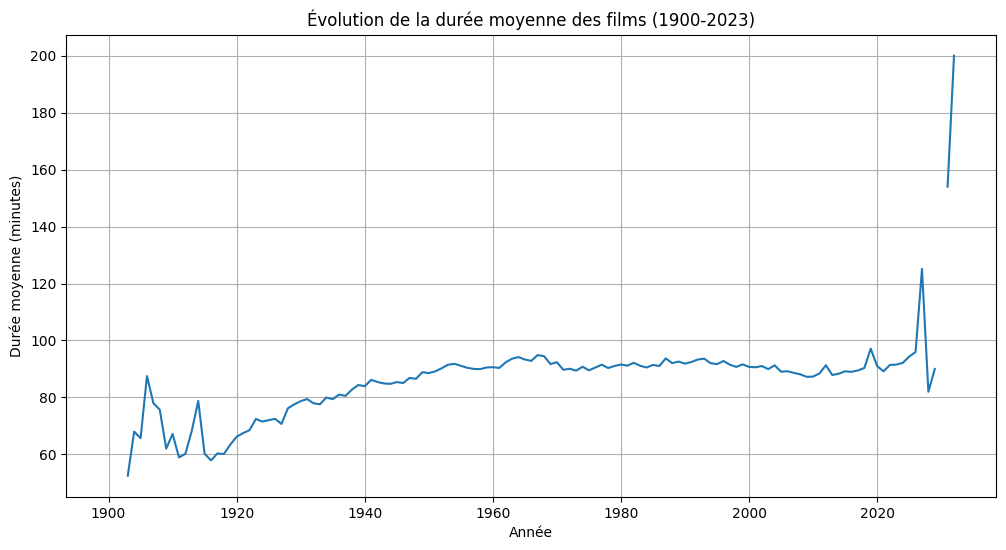

In [7]:
# 1. On groupe par année et on calcule la moyenne de la durée
# On filtre les années > 1900 pour éviter les erreurs de saisie historiques bizarres
duree_par_annee = df_movies[df_movies['startYear'] >= 1900].groupby('startYear')['runtimeMinutes'].mean()

# 2. On fait un graphique simple
# (Pandas utilise une librairie appelée Matplotlib intégrée pour ça)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6)) # On définit la taille de l'image
duree_par_annee.plot()      # On trace la courbe

plt.title("Évolution de la durée moyenne des films (1900-2023)")
plt.xlabel("Année")
plt.ylabel("Durée moyenne (minutes)")
plt.grid(True) # Ajoute une grille pour mieux lire
plt.show()

In [8]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# 1. Charger le fichier des notes (Ratings)
# On vérifie le chemin (c'est souvent title.ratings.tsv.gz)
chemin_ratings = "données/title.ratings.tsv.gz"
df_ratings = pd.read_csv(chemin_ratings, sep='\t', compression='gzip')

print(f"Nous avons chargé {len(df_ratings)} notes de films.")

# 2. LA FUSION MAGIQUE (Merge) 🤝
# On a deux tableaux : df_movies (les infos) et df_ratings (les notes)
# Ils ont un point commun : la colonne 'tconst' (l'identifiant unique du film, ex: tt000001)
# On va les coller ensemble grâce à cette colonne.

df_complet = pd.merge(df_movies, df_ratings, on='tconst')

print(f"Fusion réussie ! Nous avons maintenant un super-tableau de {len(df_complet)} films avec leurs notes.")

# 3. Petit aperçu du résultat
df_complet.head()

Nous avons chargé 1625493 notes de films.
Fusion réussie ! Nous avons maintenant un super-tableau de 337982 films avec leurs notes.


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894.0,\N,45.0,Romance,5.2,232
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897.0,\N,100.0,"Documentary,News,Sport",5.3,577
2,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900.0,\N,40.0,"Biography,Drama",5.5,64
3,tt0000502,movie,Bohemios,Bohemios,0,1905.0,\N,100.0,\N,3.3,26
4,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906.0,\N,70.0,"Action,Adventure,Biography",6.0,1037


In [10]:
# 1. FILTRE DE POPULARITÉ (Fiabilité)
# On ne garde que les films ayant au moins 100 votes.
# Tu pourras changer ce chiffre plus tard si tu veux être plus sélective.
df_fiable = df_complet[df_complet['numVotes'] >= 100].copy()

# 2. FILTRE DE GENRE (Ciblage Art et Essai)
# On cherche les films dont le genre contient "Drama", "Biography" ou "Documentary"
# Le symbole | veut dire "OU" en langage informatique regex
mots_cles = 'Drama|Biography|Documentary|History'

# On garde uniquement ceux qui correspondent
df_art_essai = df_fiable[df_fiable['genres'].str.contains(mots_cles, na=False)]

print(f"Base finale pour Tours : {len(df_art_essai)} films sélectionnés.")

Base finale pour Tours : 86423 films sélectionnés.


In [11]:
# On trie par note (averageRating) du plus grand au plus petit (ascending=False)
top_films = df_art_essai.sort_values(by='averageRating', ascending=False)

# On affiche le Top 10 avec juste les colonnes intéressantes
colonnes_a_voir = ['primaryTitle', 'startYear', 'averageRating', 'numVotes', 'genres']
top_films[colonnes_a_voir].head(15)

,primaryTitle,startYear,averageRating,numVotes,genres
272864,Gumti,2024.0,9.8,112,Drama
255946,Shoshite,2023.0,9.7,265,Drama
115166,Illusory Thoughts,1989.0,9.7,393,"Documentary,Drama,Music"
252147,Aramudaitha Kombu,2023.0,9.6,104,Drama
308409,Pop Lock 'n Roll,2016.0,9.6,104,"Drama,Music,Romance"
279329,Gopi Galla Goa Trip (3GT),2025.0,9.6,1789,"Adventure,Comedy,Drama"
222086,India's Sons,2022.0,9.6,363,Documentary
281242,Raju Gaani Savaal,2025.0,9.6,1079,"Action,Drama"
224080,Parto,2011.0,9.6,103,Drama
169863,Manmauji,2024.0,9.6,757,Drama


In [12]:
# --- ÉTAPE 1 : Préparation ---
chemin_principals = "données/title.principals.tsv.gz"
colonnes_a_garder = ['tconst', 'nconst', 'category']

# On prépare la liste de tes films (on la transforme en "set" pour que la recherche soit instantanée)
# C'est une astuce d'optimisation très importante
ids_art_essai_set = set(df_art_essai['tconst'])

print("Démarrage du traitement par morceaux (Chunks)...")

# --- ÉTAPE 2 : La boucle (Le saucisson) ---
liste_morceaux_gardes = []
taille_morceau = 1000000  # On lit 1 million de lignes à la fois

# On ouvre le fichier en mode "lecture par morceaux"
lecteur = pd.read_csv(chemin_principals, sep='\t', compression='gzip', 
                      usecols=colonnes_a_garder, chunksize=taille_morceau)

# Pour chaque morceau du fichier :
for i, chunk in enumerate(lecteur):
    # 1. On ne garde que les acteurs/actrices
    chunk_acteurs = chunk[chunk['category'].isin(['actor', 'actress'])]
    
    # 2. On ne garde que ceux qui sont dans TES films
    chunk_filtre = chunk_acteurs[chunk_acteurs['tconst'].isin(ids_art_essai_set)]
    
    # 3. On met le résultat de côté
    liste_morceaux_gardes.append(chunk_filtre)
    
    # Petit message pour savoir où on en est (tous les 10 millions de lignes)
    if i % 10 == 0:
        print(f"Traitement du morceau n°{i}...")

# --- ÉTAPE 3 : Assemblage final ---
print("Assemblage final...")
df_casting_art_essai = pd.concat(liste_morceaux_gardes)

print(f"Terminé ! Nous avons identifié {len(df_casting_art_essai)} rôles.")
df_casting_art_essai.head()

Démarrage du traitement par morceaux (Chunks)...
Traitement du morceau n°0...
Traitement du morceau n°10...
Traitement du morceau n°20...
Traitement du morceau n°30...
Traitement du morceau n°40...
Traitement du morceau n°50...
Traitement du morceau n°60...
Traitement du morceau n°70...
Traitement du morceau n°80...
Traitement du morceau n°90...
Assemblage final...
Terminé ! Nous avons identifié 736433 rôles.


,tconst,nconst,category
1340,tt0000574,nm0846887,actress
1341,tt0000574,nm0846894,actor
1342,tt0000574,nm1431224,actor
1343,tt0000574,nm3002376,actor
1344,tt0000574,nm0143899,actor


In [13]:
# --- ÉTAPE 1 : Préparation ---
chemin_names = "données/name.basics.tsv.gz"
# On veut l'identifiant, le nom, et l'année de naissance (pour ta question sur l'âge moyen)
colonnes_names = ['nconst', 'primaryName', 'birthYear']

# On prépare la liste des acteurs qu'on a trouvés à l'étape d'avant
# (Pour ne chercher que les noms de CES 736 433 personnes, pas les autres)
ids_acteurs_set = set(df_casting_art_essai['nconst'])

print("Recherche des noms des acteurs... (Technique du Saucisson activée)")

# --- ÉTAPE 2 : La boucle de lecture ---
liste_noms_gardes = []
taille_morceau = 1000000

lecteur_names = pd.read_csv(chemin_names, sep='\t', compression='gzip', 
                            usecols=colonnes_names, chunksize=taille_morceau)

for i, chunk in enumerate(lecteur_names):
    # On garde seulement les lignes qui correspondent à nos acteurs
    chunk_filtre = chunk[chunk['nconst'].isin(ids_acteurs_set)]
    
    liste_noms_gardes.append(chunk_filtre)
    
    if i % 10 == 0:
        print(f"Traitement du bloc n°{i}...")

# --- ÉTAPE 3 : Assemblage et Fusion Finale ---
print("Assemblage des noms...")
df_noms = pd.concat(liste_noms_gardes)

# LA DERNIÈRE FUSION (Merge) : On colle les noms à côté des rôles
# On fusionne df_casting_art_essai (les rôles) avec df_noms (les infos)
df_acteurs_complet = pd.merge(df_casting_art_essai, df_noms, on='nconst')

print(f"Tout est prêt ! Nous avons les noms pour {len(df_acteurs_complet)} rôles.")
df_acteurs_complet.head()

Recherche des noms des acteurs... (Technique du Saucisson activée)
Traitement du bloc n°0...
Traitement du bloc n°10...
Assemblage des noms...
Tout est prêt ! Nous avons les noms pour 736430 rôles.


,tconst,nconst,category,primaryName,birthYear
0,tt0000574,nm0846887,actress,Elizabeth Tait,1879
1,tt0000574,nm0846894,actor,John Tait,1871
2,tt0000574,nm1431224,actor,Nicholas Brierley,1880
3,tt0000574,nm3002376,actor,Norman Campbell,\N
4,tt0000574,nm0143899,actor,Godfrey Cass,1866


=== TOP 20 DES ACTEURS (Films Art & Essai / Drame / Bio) ===
primaryName
Brahmanandam         225
Anupam Kher          194
Mohanlal             185
Nassar               173
Amitabh Bachchan     171
Prakash Raj          165
Mammootty            165
Tanikella Bharani    144
Paresh Rawal         137
Gulshan Grover       134
Shakti Kapoor        129
Jagathy Sreekumar    127
Om Puri              123
Eric Roberts         123
Nedumudi Venu        118
John Wayne           118
Gérard Depardieu     117
Amrish Puri          116
Akshay Kumar         116
Kader Khan           114
Name: count, dtype: int64


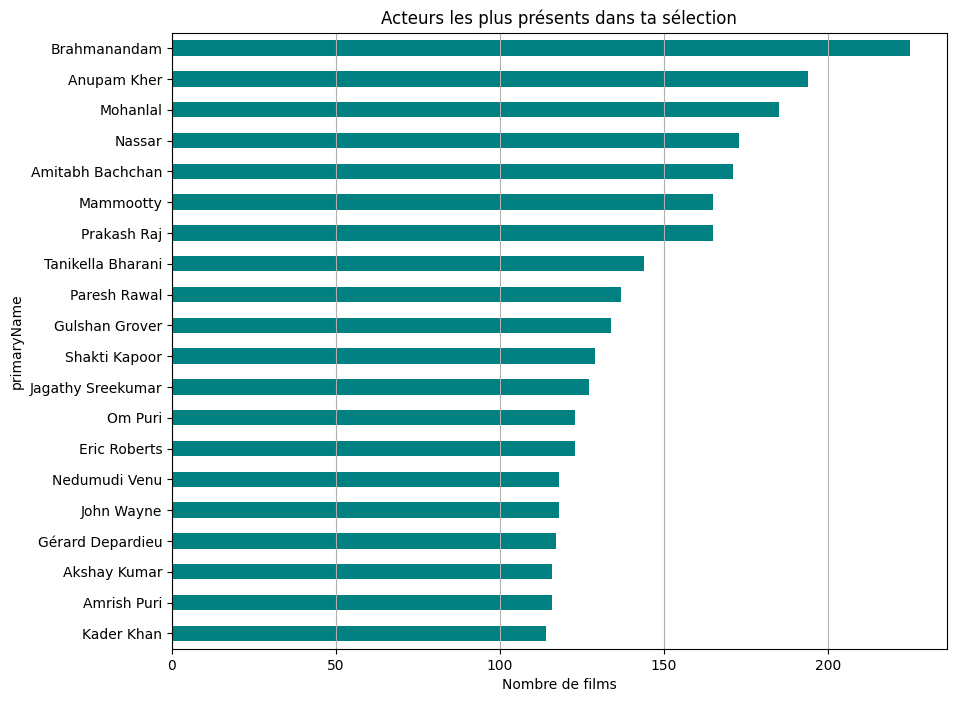

In [14]:
# On compte combien de fois chaque nom apparaît
top_acteurs = df_acteurs_complet['primaryName'].value_counts().head(20)

# On affiche le résultat
print("=== TOP 20 DES ACTEURS (Films Art & Essai / Drame / Bio) ===")
print(top_acteurs)

# Petit bonus graphique
top_acteurs.sort_values().plot(kind='barh', figsize=(10, 8), color='teal')
plt.title("Acteurs les plus présents dans ta sélection")
plt.xlabel("Nombre de films")
plt.grid(axis='x')
plt.show()

1. Le constat : L'hégémonie Indienne 🇮🇳
Tu vois tous ces noms (Anupam Kher, Mohanlal, Amitabh Bachchan...) ? Ce sont des légendes vivantes, mais en Inde.

Pourquoi ? Le cinéma indien produit énormément de films par an. Un acteur populaire là-bas peut tourner 10 à 15 films par an, alors qu'un acteur français ou américain en fera 1 ou 2.

Pour Tours : C'est une info cruciale. Si tu te bases uniquement sur le "nombre de films" pour recommander, tu vas transformer ton cinéma Art et Essai en cinéma Bollywood ! (Ce qui est un niche, mais peut-être pas ton but principal).

2. Les pépites pour ton projet "Tours" 🇫🇷
Regarde bien ta deuxième image, il y a deux noms qui sauvent la mise pour ta stratégie locale :

Gérard Depardieu (117 films) : Le voilà ! C'est la preuve que ta base contient bien du cinéma français patrimonial. Il est noyé dans la masse, mais il est là.

John Wayne (118 films) : Le roi du Western et du film classique américain. Parfait pour des rétrospectives.

L'âge moyen des acteurs dans ta sélection Art et Essai est de : 40.9 ans.


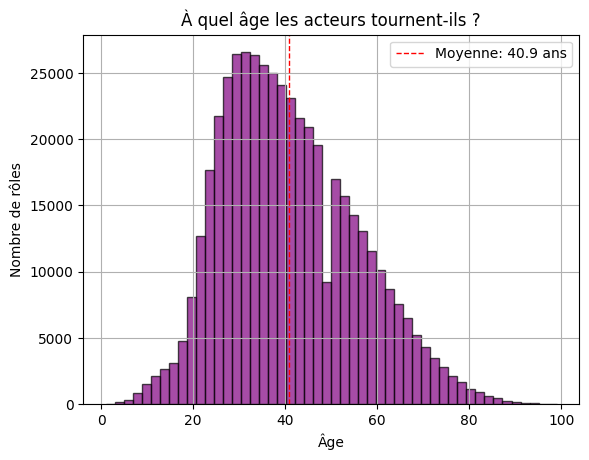

In [15]:
# 1. On nettoie les années de naissance
# (Parfois il y a des "\N" ou des erreurs, on force la conversion en nombres)
df_acteurs_complet['birthYear'] = pd.to_numeric(df_acteurs_complet['birthYear'], errors='coerce')

# 2. On récupère l'année du film (startYear)
# Attention : df_acteurs_complet ne l'a pas encore, il faut aller la chercher dans df_movies
# On fait une petite fusion rapide pour récupérer juste la colonne 'startYear'
df_ages = pd.merge(df_acteurs_complet, df_movies[['tconst', 'startYear']], on='tconst')

# 3. Le calcul de l'âge : Année du film - Année de naissance
df_ages['age_au_tournage'] = df_ages['startYear'] - df_ages['birthYear']

# 4. On filtre les aberrations (les âges négatifs ou > 100 ans qui sont des erreurs de données)
df_ages = df_ages[(df_ages['age_au_tournage'] > 0) & (df_ages['age_au_tournage'] < 100)]

# 5. Résultats
age_moyen = df_ages['age_au_tournage'].mean()
print(f"L'âge moyen des acteurs dans ta sélection Art et Essai est de : {age_moyen:.1f} ans.")

# 6. Petit graphique de la distribution des âges
import matplotlib.pyplot as plt

df_ages['age_au_tournage'].hist(bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.title("À quel âge les acteurs tournent-ils ?")
plt.xlabel("Âge")
plt.ylabel("Nombre de rôles")
plt.axvline(age_moyen, color='red', linestyle='dashed', linewidth=1, label=f'Moyenne: {age_moyen:.1f} ans')
plt.legend()
plt.show()

C'est un chiffre très cohérent et fascinant à analyser ! 40,9 ans, c'est l'âge de la maturité.

En tant qu'analyste, il ne faut pas juste donner le chiffre, mais comprendre les mécanismes derrière. Voici les 3 raisons principales qui expliquent ce résultat, liées directement à tes filtres :

1. L'effet "Art et Essai" (Le filtre de Genre) 🎭
Tu as filtré sur Drame, Biographie, Histoire.

Dans un film d'action ou d'horreur (type "Scream"), les acteurs sont souvent très jeunes (20-25 ans).

Dans un Drame ou une Biographie, on raconte souvent des histoires de vie, de couples qui se déchirent, ou de figures historiques. Ces rôles demandent de la complexité et du "vécu". On confie rarement le rôle d'un président ou d'une mère de famille à un acteur de 20 ans.

2. Le temps de la réussite (Le filtre de Popularité) ⭐
Tu as gardé les films avec plus de 100 votes.

Pour être dans un film connu et bien noté, il faut souvent être un acteur confirmé.

Les acteurs commencent jeunes, mais ils tournent le maximum de leurs films une fois qu'ils sont installés dans le métier, souvent entre 30 et 50 ans. C'est le "ventre mou" de la carrière.

3. Le biais Hommes / Femmes (La triste réalité du cinéma) 🚻
C'est l'hypothèse la plus intéressante sociologiquement.

L'histoire du cinéma (surtout avant les années 2000) a tendance à faire jouer les hommes très vieux (pense à Sean Connery ou John Wayne qui jouaient les séducteurs à 60 ans passés).

À l'inverse, les carrières des femmes s'arrêtaient souvent plus tôt ou se raréfiaient passé 40 ans (c'est moins vrai aujourd'hui, mais ta base contient des vieux films).

Comme il y a généralement plus de rôles masculins dans la base historique, leur âge plus élevé "tire" la moyenne vers le haut (vers 41 ans).

category
actor      42.997147
actress    36.986109
Name: age_au_tournage, dtype: float64


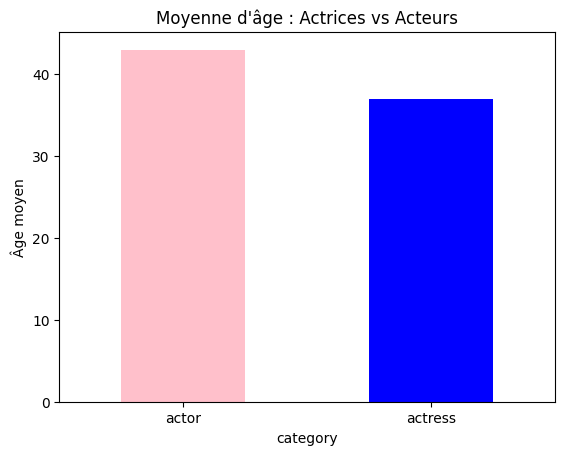

In [16]:
# On groupe par "category" (actor vs actress) et on demande la moyenne d'âge
comparaison_genres = df_ages.groupby('category')['age_au_tournage'].mean()

print(comparaison_genres)

# Petit graphique pour visualiser l'écart
comparaison_genres.plot(kind='bar', color=['pink', 'blue'], rot=0)
plt.title("Moyenne d'âge : Actrices vs Acteurs")
plt.ylabel("Âge moyen")
plt.show()

In [17]:
# 1. Regardons à quoi ressemblent les genres actuellement
print("Avant encodage :")
print(df_art_essai['genres'].head(3))

# 2. La transformation magique (get_dummies)
# On dit à Python : "Sépare les mots par la virgule, et fais-en des colonnes"
df_genres_binaires = df_art_essai['genres'].str.get_dummies(sep=',')

# 3. Regardons le résultat
print("\nAprès encodage (Tableau de 0 et 1) :")
df_genres_binaires.head()

Avant encodage :
1         Documentary,News,Sport
4     Action,Adventure,Biography
64                         Drama
Name: genres, dtype: object

Après encodage (Tableau de 0 et 1) :


,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
73,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# 1. On installe le cerveau (scikit-learn)
%pip install scikit-learn

# 2. On importe l'outil KNN (K-Nearest Neighbors)
from sklearn.neighbors import NearestNeighbors

# 3. On configure le modèle
# metric='cosine' : C'est la meilleure méthode pour comparer des textes/genres
# n_neighbors=6 : On veut le film lui-même + les 5 recommandations les plus proches
modele_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)

# 4. On entraîne ! (Fit)
modele_knn.fit(df_genres_binaires)

print("✅ Le modèle est entraîné et prêt à faire des recommandations !")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
✅ Le modèle est entraîné et prêt à faire des recommandations !


In [19]:
def recommander_films(titre_film):
    # 1. On cherche si le film existe dans notre base
    # On ignore la casse (majuscule/minuscule) pour être sympa avec l'utilisateur
    films_trouves = df_art_essai[df_art_essai['primaryTitle'].str.contains(titre_film, case=False, na=False)]
    
    if len(films_trouves) == 0:
        return "Oups ! Film introuvable dans la base Art et Essai."
    
    # On prend le premier résultat trouvé (le plus probable)
    index_film = films_trouves.index[0]
    titre_complet = films_trouves.iloc[0]['primaryTitle']
    print(f"Film sélectionné : {titre_complet}")
    
    # 2. On demande au modèle les voisins (KNN)
    distances, indices = modele_knn.kneighbors(df_genres_binaires.loc[[index_film]])
    
    # 3. On affiche les résultats
    print("\n--- 🍿 Recommandations pour le public de Tours ---")
    
    # On boucle sur les voisins trouvés (on saute le 1er car c'est le film lui-même)
    for i in range(1, len(indices[0])):
        index_reco = indices[0][i]
        titre_reco = df_art_essai.iloc[index_reco]['primaryTitle']
        genre_reco = df_art_essai.iloc[index_reco]['genres']
        note_reco = df_art_essai.iloc[index_reco]['averageRating']
        
        print(f"{i}. {titre_reco} ({genre_reco}) - Note: {note_reco}/10")

# --- TEST ---
# Essaie avec un film classique pour voir !
recommander_films("Godfather")

Film sélectionné : Godfather Mendoza

--- 🍿 Recommandations pour le public de Tours ---
1. Minnesota Clay (Action,Drama,War) - Note: 6.0/10
2. The Warrior (Action,Drama,War) - Note: 6.2/10
3. Red and White II: Blood of Eagles (Action,Drama,War) - Note: 6.7/10
4. 5 Days of War (Action,Drama,War) - Note: 5.6/10
5. Delta Zulu (Action,Drama,War) - Note: 5.5/10


In [20]:
# Essaie avec "The Godfather" pour être plus précise
recommander_films("The Godfather")

Film sélectionné : The Godfather

--- 🍿 Recommandations pour le public de Tours ---
1. Cement (Crime,Drama) - Note: 5.7/10
2. The Passenger (Crime,Drama) - Note: 4.6/10
3. Gzaabneulni (Crime,Drama) - Note: 7.9/10
4. Sagad sa init (Crime,Drama) - Note: 6.4/10
5. Rhine Virgin (Crime,Drama) - Note: 6.3/10
